# Pulse profile optimization

In this notebook, we optimize the pulse profile used in the final computation in `main_algorithm.ipynb`. The optimization approach follows the method outlined in the paper [Quantum Optimization of Maximum Independent Set using Rydberg Atom Arrays](https://arxiv.org/abs/2202.09372), where the detuning is divided into time intervals. According to the paper, for graphs of the same size, the "optimal parameters" for the pulse remain relatively constant. To demonstrate this, we use an example grid of size `max_grid_points` (set to 10), which is generated using adaptive selection from a triangular grid with a minimum distance threshold. The optimized pulse parameters are then applied to identify the Maximum Independent Set (MIS) for each city.

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
from scipy.spatial import KDTree, distance
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import json
# graph representation
import networkx as nx
# Pulser imports
import pulser as pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice
from pulser.waveforms import InterpolatedWaveform, RampWaveform, ConstantWaveform

### Extract the city data

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[0]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])

In [3]:
# function to compute coverage of an array of grid_points
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    return z_coverage
    

### Generate a grid

We generate a triangular grid and adaptively select `max_grid_points` from the triangular grid. We take `max_grid_points` equal to 10 to minimize the time taken for Qutip emulator to run the quantum program. 

In [4]:

def generate_triangular_grid(side_lengths, spacing, offset):
    """
    Generates a grid of points in a triangular (hexagonal) lattice pattern.

    Parameters:
    - side_lengths: Tuple (rows, cols) representing the number of rows and columns in the grid.
    - spacing: Distance between adjacent points in the grid.
    - offset: Tuple (x_offset, y_offset) that shifts the entire grid by these values.

    Returns:
    - points: List of [x, y] coordinates for each point in the triangular grid.
    """
    rows, cols = side_lengths
    points = []  # Initialize an empty list to store grid points
    for row in range(rows): # Loop through each row
        for col in range(cols): # Loop through each column in the row
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

# Function to adaptively select points from a triangular grid with minimum interference
def adaptive_selection_with_min_dist(grid_points, max_grid_points,interference_threshold):
    """
    Selects up to a specified number of points from a grid while ensuring a minimum distance between selected points.

    Parameters:
    - grid_points: List of [x, y] coordinates in the initial grid.
    - max_grid_points: Maximum number of points to select.
    - interference_threshold: Minimum allowable distance between any two selected points.

    Returns:
    - selected_points: List of selected [x, y] coordinates that meet the interference threshold criteria.
    """
    selected_points = []
    while len(selected_points) < max_grid_points and grid_points:
        # Choose the point with the best coverage from remaining points
        point = grid_points.pop(0)
        # Calculate interference with selected points
        if selected_points:
            dists_to_selected = distance.cdist([point], selected_points, 'euclidean')
            min_dist_to_selected = np.min(dists_to_selected)

            # Skip this point if it interferes too much with any selected point
            if min_dist_to_selected < interference_threshold:
                continue
        # Select this point
        selected_points.append(point) 
    return selected_points

In [5]:
# Define parameters
population_x = x
population_y = y
offset = [population_x.min(), population_y.min()]  # Offset to start grid at (0, 0)
R_antennas = 25  # Operating radius for each antenna
spacing = R_antennas/3  # Use a small spacing for high precision
side_lengths = (
        int(np.ceil((population_x.max() - population_x.min()) / spacing)),
        int(np.ceil((population_y.max() - population_y.min()) / spacing))
    )

max_grid_points = 10 # Maximum number of antennas
interference_threshold = 1.5*R_antennas  #minimum distance between gridpoints
grid_points = adaptive_selection_with_min_dist(generate_triangular_grid(side_lengths, spacing, offset), max_grid_points, interference_threshold)

# Calculate final coverage for the selected grid layout
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)

### Device selection

We choose the `MockDevice` and embedd the `grid_points` to the register coordinate with appropriate scaling.

In [6]:
device_used = pulser.devices.MockDevice
# create an UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
factor = 5/val
coords = coords*factor # Normalize to 5 b.c. minimum distance on real NAQC is around 4um

# set Rabi frequency and detuning 
# Parameters in rad/µs and ns
omega_max = 2 * np.pi   # the maximum Rabi frequency, stays constant throughout the code
delta_0 = -6 * omega_max
delta_f = 2 * omega_max
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

# scaling of the graph to map it inside the register
rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
R_antennas = 25*factor
factor_for_rydberg_scaling = rydberg_radius/(2*R_antennas)
R_antennas = R_antennas * factor_for_rydberg_scaling
coords = coords * factor_for_rydberg_scaling

# Noise configuration
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}
print('Omega_max:', omega_max)
print('Rydberg radius:', rydberg_radius)
print('Delta_0:', delta_0)
print('Delta_f:', delta_f)
print('t_rise:', t_rise)
print('t_fall:', t_fall)
print('t_sweep:', t_sweep)

Omega_max: 6.283185307179586
Rydberg radius: 9.756753962298905
Delta_0: -37.69911184307752
Delta_f: 12.566370614359172
t_rise: 252
t_fall: 500
t_sweep: 800.0


### Extract Q for the QUBO cost function

In [7]:
# interaction coefficients U_ij
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
# fill the diagonal with negative of the coverage of each grid point
np.fill_diagonal(Q, -z_coverage)

### Create the register

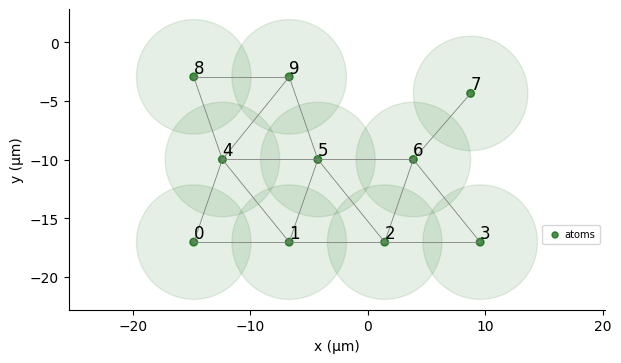

In [8]:
# create a register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

{0: Text(-14.826376546173297, -17.022364529129952, '0'),
 1: Text(-6.695748244257539, -17.022364529129952, '1'),
 2: Text(1.434880057658216, -17.022364529129952, '2'),
 4: Text(-12.387188055598568, -9.981033870942174, '4'),
 5: Text(-4.256559753682814, -9.981033870942174, '5'),
 9: Text(-6.695748244257539, -2.9397032127543974, '9'),
 3: Text(9.565508359573972, -17.022364529129952, '3'),
 6: Text(3.874068548232942, -9.981033870942174, '6'),
 7: Text(8.752445529382396, -4.347969344391953, '7'),
 8: Text(-14.826376546173297, -2.9397032127543974, '8')}

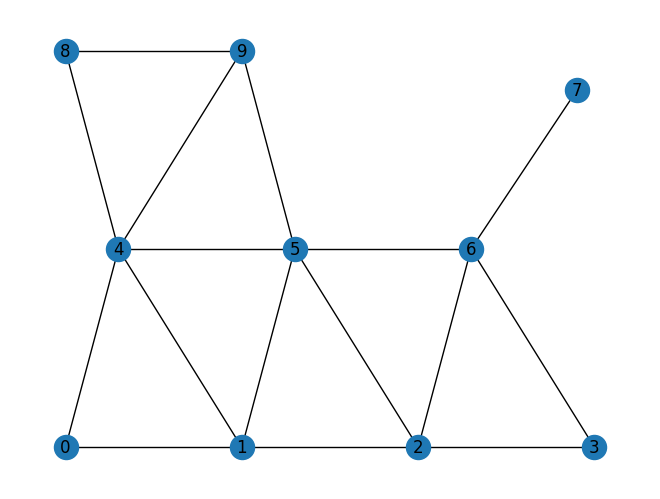

In [9]:
graph = nx.Graph()
edges = KDTree(coords).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

### Utility functions

In [10]:
def create_pulse(Omega_max, t_omega, detuning_values, detuning_times):
    """
    Create a list of Pulse objects that defines a pulse sequence with different amplitude and detuning profiles.

    Parameters:
    - Omega_max: Maximum amplitude for the Rabi oscillations.
    - t_omega: Tuple of rise and fall times (rabi_t_rise, rabi_t_fall) for reaching and decreasing to/from Omega_max.
    - detuning_values: List of detuning values to be used in different stages of the pulse.
    - detuning_times: List of time intervals associated with each detuning value.

    Returns:
    - list_pulses: A list of Pulse objects defining the sequence of pulses with specified amplitude and detuning profiles.
    """

    # Initialize an empty list to store the pulse sequence
    list_pulses = []
    # 1. rise to omega_max with 0 detuning
    rabi_t_rise, rabi_t_fall = t_omega
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_rise, 0, Omega_max), 
        detuning=detuning_values[0], 
        phase=0)
        )
    
    # 2. Rampwaveforms from \Delta_{min} to \Delta_{max} with constant Omega_max
    counter = 0
    for i in range(time_interval_number):
        if i % 2 ==0: 
            # For even indices, use a ramp waveform for detuning, from detuning_values[counter] to detuning_values[counter+1]
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=RampWaveform(detuning_times[i], detuning_values[counter], detuning_values[counter+1]),
                phase=0
                ))
            counter += 1
        else:
            # For odd indices, use a constant detuning with the current detuning value
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=ConstantWaveform(detuning_times[i], detuning_values[counter]),
                phase=0
                ))
    # 3. fall to 0 with \Delta_f detuning
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_fall, Omega_max, 0), 
        detuning=detuning_values[-1], 
        phase=0)
        )
    return list_pulses
   

In [11]:
def create_sequence(omega_max, register, device_used, detunings_number, time_interval_number):
    """
    Create a parametrized pulse sequence with variable detuning and timing intervals.

    Parameters:
    - omega_max: The maximum Rabi frequency for the pulses.
    - register: The qubit or atom register for the sequence.
    - device_used: The device used for generating the pulse.
    - detunings_number: Number of detuning values required in the sequence.
    - time_interval_number: Number of time intervals for detuning adjustments.

    Returns:
    - parametrized_sequence: A Sequence object containing the pulse sequence with variable amplitude and detuning.
    """

    # Initialize the parametrized sequence with specified register and device
    parametrized_sequence = Sequence(register, device_used)

    # Declare a communication channel for the sequence, named "rydberg"
    parametrized_sequence.declare_channel("rydberg", "rydberg_global")

    # Define variables for the time to ramp up to and ramp down from Omega_max
    # t_omega has two values: rise time and fall time (both are integer types)
    t_omega = parametrized_sequence.declare_variable("t_omega", size=2, dtype=int)

    # detunings values
    detuning_values = parametrized_sequence.declare_variable("detuning_values", size=detunings_number, dtype=float)

    # detuning times intervals
    detuning_times = parametrized_sequence.declare_variable("detuning_times", size=time_interval_number, dtype=int)

    # Create a list of pulses using the create_pulse function
    list_pulses = create_pulse(omega_max, t_omega, detuning_values, detuning_times)

    # Add each pulse to the sequence, specifying the "rydberg" channel for each pulse
    for i in range(len(list_pulses)):
        parametrized_sequence.add(list_pulses[i], "rydberg")
    return parametrized_sequence


In [12]:
# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

### Choice of cost functions

The quantum algorithm to find MIS returns a dictionary containing possible MIS and their probability of occuring. We use this dictionary to have two cost functions for our pulse optimization:
- Option 1: calculates the weighted mean size of all the potential MIS returned by the quantum algorithm to find MIS.
- Option 2: calculates average cost using QUBO cost matrix `Q` over all the configurations of potential MIS sampled by the quantum program.

In our code, we use Option 1 as suggested in https://arxiv.org/pdf/2202.09372.

#### Option 1:

In [13]:
# Function to return the size of the Maximum Independent Set (MIS)
def mis_size(graph, bitstring):
    """
    Calculates the size of the independent set represented by the bitstring for a given graph.
    
    Parameters:
    - graph: The graph in which the independent set is being checked.
    - bitstring: A binary string representing nodes in the independent set (1 if node is in the set, 0 otherwise).
    
    Returns:
    - Size of the independent set if it is valid, otherwise a penalty (-4) if the set is not independent.
    """

    # Convert the bitstring into a list of node indices representing the independent set
    node_set = convert_to_indices(bitstring)
    
    # Check if the node set is an independent set
    for node in node_set:
        for neighbor in graph.neighbors(node):
            if neighbor in node_set:  # If any neighbor of a node in the set is also in the set, it is not an independent set
                return -4  # Return penalty if not an independent set
    
    # Return the size of the independent set if it passes the check
    return len(node_set)

# Function to calculate the weighted mean size of the MIS from a set of solutions
def mean_mis_size(graph, solution_dict):
    """
    Calculates the weighted mean size of Maximum Independent Sets (MIS) based on solutions provided in solution_dict.
    
    Parameters:
    - graph: The graph in which the MIS is being calculated.
    - solution_dict: Dictionary with bitstrings as keys and counts as values. Each bitstring represents a possible
      independent set, and the count represents how often this set was observed.
    
    Returns:
    - mean_size: The weighted mean size of the MIS across all solutions, accounting for penalties and frequencies.
    """

    total_weighted_size = 0  # Sum of weighted sizes for each solution
    total_counts = 0  # Total count of solutions
    list_sizes = []  # List to store the sizes of each solution's MIS

    # Iterate over each bitstring and its count in the solution dictionary
    for bitstring, count in solution_dict.items():
        list_sizes.append(mis_size(graph, bitstring))  # Get the size of the independent set or penalty
    
    # Identify the maximum size of all independent sets found
    max_size = max(list_sizes)
    # Replace all penalty values in list_sizes with 0 to exclude them from contributing to the mean
    updated_list_sizes = [size if size == max_size else 0 for size in list_sizes]  

    # Calculate the weighted total size and total counts for the mean
    for size, count in zip(updated_list_sizes, solution_dict.values()):
        total_weighted_size += size * count
        total_counts += count

    mean_size = total_weighted_size / total_counts

    return mean_size  # Return the mean size of the MIS

#### Option 2:

In [14]:
# Function to calculate the cost of a particular configuration in a potential MIS
def get_cost_colouring(bitstring):
    """
    Computes the cost of a configuration represented by a bitstring for a given MIS problem.
    
    Parameters:
    - bitstring: A binary string representing the configuration (1 if node is included in the independent set, 0 otherwise).
    
    Returns:
    - cost: The computed cost derived from the QUBO matrix Q.
    """  
    # Convert the bitstring to an integer array where each element is 0 or 1
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost #return the computed cost

# Function to calculate the average cost across all sampled configurations of potential MIS
def get_cost(counter):
    """
    Computes the average cost of potential MIS configurations sampled by a quantum program.
    
    Parameters:
    - counter: A dictionary where each key is a bitstring representing a configuration, and each value is the 
      count (frequency) of that configuration.
    
    Returns:
    - Average cost of all configurations, weighted by their frequencies.
    """
    cost = sum(counter[key] * get_cost_colouring(key) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

### Quantum program to sample potential MIS and finding cost


In [15]:

def quantum_loop(param, omega_max, device_used, reg, detunings_number):
    """
    Simulates the quantum process with a given parameter set and calculates the cost.
    
    Parameters:
    - param: A set of parameters to be used in the simulation, including the Rabi frequency,
             detuning values, and detuning times.
    - omega_max: Maximum Rabi frequency (used in pulse generation).
    - device_used: The quantum device or register being used in the simulation.
    - reg: The quantum register for which the sequence is generated.
    - detunings_number: The number of detuning values to be considered.
    
    Returns:
    - mean_size: The cost of corresponding to the particular parameters.
    """
    # Retrieve and split the parameters from the flattened input
    t_omega_param = param[0:2]
    detuning_values_param = param[2:2+detunings_number]
    detuning_times_param = param[2+detunings_number:]
    
    # Create a parametrized sequence based on the provided parameters
    parametrized_sequence = create_sequence(omega_max, reg, device_used, len(detuning_values_param), len(detuning_times_param))
    # build the sequence
    sequence = None
    try:
        sequence = parametrized_sequence.build(
            t_omega=t_omega_param,
            detuning_times = detuning_times_param, 
            detuning_values = detuning_values_param,
        )
    except:
        return 1000 # Return a high value (1000) to indicate an invalid sequence generation
    
    # simulation with Qutip emulator
    simulator = QutipEmulator.from_sequence(
        sequence, 
        sampling_rate=1,
        with_modulation = False,
        config=noise_config["noiseless"],
    )
    #simulator.show_config()
    results = simulator.run(progress_bar=False)
    count_dict = results.sample_final_state(N_samples=10000)
    
    # Use Option 1 as the cost function
    # create an ordered dictionnary of the results
    most_frequent = {k:v for k,v in count_dict.items() if v>10}
    results_dictionnary = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
    
    mean_size = mean_mis_size(graph, results_dictionnary)
    
    # Comment above 3 lines and uncomment the following to use Option 2
    #mean_size = get_cost(count_dict)        # Used Option 2 as the cost function
    return mean_size


### Optimization
This optimization is performed by iteratively adjusting the parameters to find the optimal configuration that minimizes the cost. The function leverages the `minimize` function from `scipy.optimize`. Thoughout the whole program, `omega_max` does not change as otherwise the Rydberg blockade radius changes. The parameters that we are optimizing are:
- `t_omega`: 1-D array containing `t_rise` and `t_fall`, the time it takes for the Rabi frequency to rise and fall,
- `detuning_times`: an array containing the time interval at which detuning changes its values,
- `detunina_values`: the values of the detuning at each time interval specified in `detuning_times`.

In [16]:
def optimization_loop(omega_max, device_used, detunings_number, initial_guess, bounds, maxiter):
    """
    Performs an optimization using the Nelder-Mead method to minimize the quantum loop cost function.

    Parameters:
    - omega_max: Maximum Rabi frequency (used in pulse generation).
    - device_used: The quantum device or register used in the simulation.
    - detunings_number: The number of detuning values to be considered in the optimization.
    - initial_guess: The initial guess for the optimization (starting point for the algorithm).
    - bounds: The bounds for the optimization variables, specifying the allowed range for each parameter.
    - maxiter: The maximum number of iterations to run the optimization.

    Returns:
    - res: The result object containing information about the optimization, including the optimal parameters
          and the final cost value.
    """
    res = minimize(
        quantum_loop,
        x0=initial_guess,
        args=(omega_max, device_used, reg, detunings_number),
        bounds=bounds,
        method='Nelder-Mead', 
        #callback= callback,  #uncomment to print each iteration parameters
        options={"return_all": True, "maxiter": maxiter, "adaptive": True},
    )
    return res

In [17]:
# Callback function to see parameters for each optimization
def callback(f):
    print(f"--> Interation parameters: {f}.")

In [ ]:
# number of segment for the detuning
detunings_number = 5

# number of time intervals for the detuning
time_interval_number = 2*detunings_number - 3

# Initial guess for the parameters 
init_t_omega = np.array([250, 500])
init_detuning_values = np.linspace(delta_0, delta_f, detunings_number)
init_detuning_times = np.array([300]*time_interval_number)

# Flatten and concatenate all parameters into a one-dimensional array
initial_guess = init_t_omega.tolist() + init_detuning_values.tolist() + init_detuning_times.tolist()

# Maximum number of iterations
maxiter = 5 # we ran it with 40 iterations, takes about 5 minutes

# Bounds for each parameter for the analog device (see: device_used.print_specs())
max_time_omega = (int)(4000/6)
max_time_detuning = (int)((4000-2*max_time_omega) / (time_interval_number))
print(f"Maximum total time {2*max_time_omega + max_time_detuning*time_interval_number}")
print(f'Max time for omega = {max_time_omega} and max time for detuning = {max_time_detuning}')
bounds = [(20, max_time_omega)]*2        # Bounds for t_omega_param (since t_omega + sum(detuning_times) <= 4000)
bounds += [(-40, 60)] * detunings_number  # Bounds for each element in detuning_values_param
bounds += [(20, max_time_detuning)] * time_interval_number    # Bounds for each element in detuning_times_param

Maximum total time 3999
Max time for omega = 666 and max time for detuning = 381


In [19]:
res = optimization_loop(omega_max, device_used, detunings_number, initial_guess, bounds, maxiter)

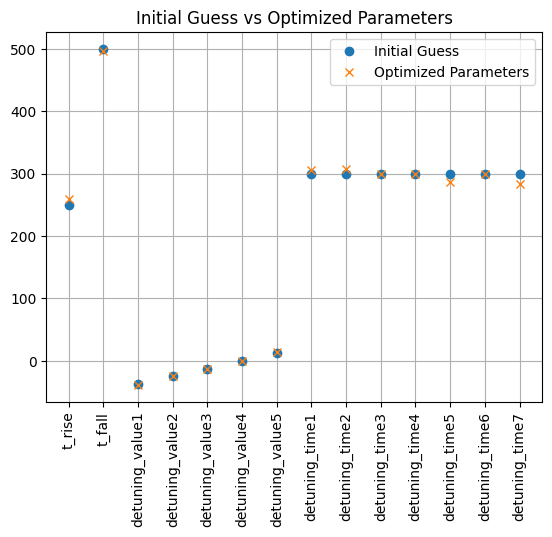

In [20]:
# Extracting the best optimized parameters from the result object of the optimization
best_params = res.x

# Plotting the initial guess values as a line with circle markers
plt.plot(initial_guess, label ='Initial Guess', marker='o', linestyle ='')

# Plotting the best optimized parameters as a line with 'x' markers
plt.plot(best_params, label = 'Optimized Parameters', marker = 'x', linestyle = '')

xticks = ["t_rise", "t_fall", "detuning_value1", "detuning_value2", "detuning_value3", "detuning_value4", 
          "detuning_value5", "detuning_time1", "detuning_time2", "detuning_time3", "detuning_time4", "detuning_time5",
          "detuning_time6", "detuning_time7"
          ]
plt.xticks(ticks=range(len(initial_guess)), labels=xticks)
plt.xticks(rotation=90)
plt.title("Initial Guess vs Optimized Parameters")
plt.grid(True)
plt.legend()
plt.show()

We note from the above plot that our initial guess for the parameters are already providing good results.

## Draw the final pulse profile

t_omega =  [258.95474202 496.54972849]
detuning_times =  [305.03444013 307.56739795 299.55510718 299.19754561 285.97458739
 298.91997198 282.80963203]
detuning_values =  [-3.84206421e+01 -2.43377506e+01 -1.27514726e+01 -7.57634652e-05
  1.36980486e+01]


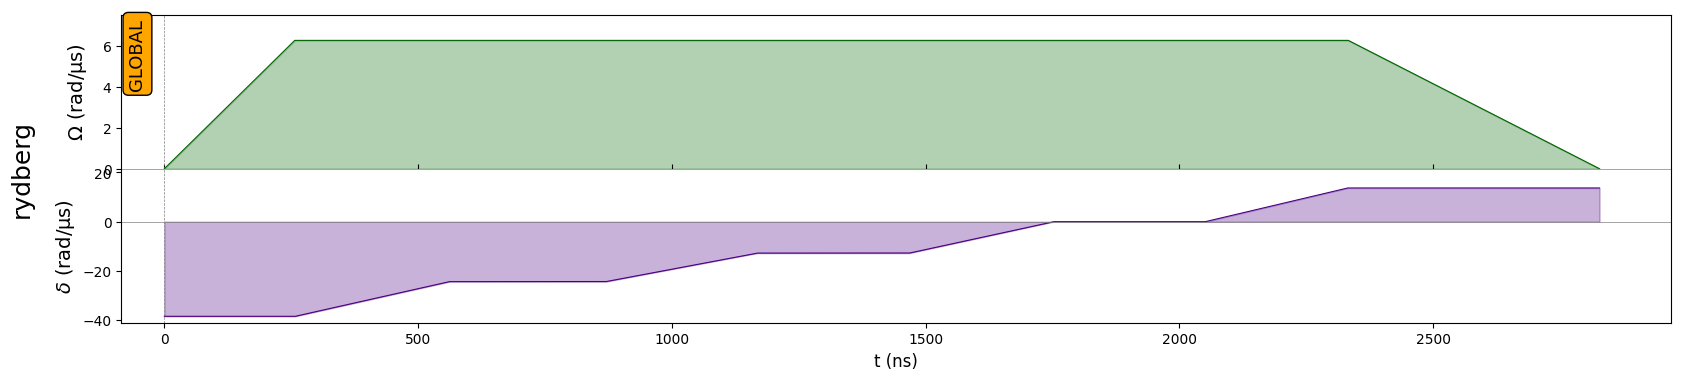

In [21]:
# retrieve the parameters
t_omega_param = res.x[0:2]
detuning_values_param = res.x[2:2+detunings_number]
detuning_times_param = res.x[2+detunings_number:]

print('t_omega = ', t_omega_param)
print('detuning_times = ', detuning_times_param)
print('detuning_values = ', detuning_values_param)

# create the sequence
parametrized_sequence = create_sequence(omega_max, reg, device_used, len(detuning_values_param), len(detuning_times_param))
# build the sequence
sequence = parametrized_sequence.build(
    t_omega=t_omega_param,
    detuning_times = detuning_times_param, 
    detuning_values = detuning_values_param,
)
sequence.draw()

In [23]:
# storing the optimized data
np.savez("./media/optimized_values.npz", omega_max = omega_max, t_omega_param = t_omega_param,  detuning_times_param = detuning_times_param, detuning_values_param =detuning_values_param)